In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('./data/isi.csv').T
isi_mat = np.array(df.where(pd.notnull(df), None))

In [3]:
def run_sim():
    #1) Initialize parameters.
    tmax = 1000
    dt = 0.01

    #1.1) Neuron/Network pairs.
    c_m = 50 # nF
    v_th = -55 # mV
    v_r = -75 # mV
    g_l = 15 # nS
    e_l = v_r # mV
    v_spike = 20 # mV

    # Bursting parameters
    tau_a = 5 # s
    k_in = 50 # Pa/s
    k_a = 5150 # Pa
    k_e = 600 # Pa

    # PIEZO channel parameters
    g_s = 25 # nS
    e_srev = 10 # mV
    s = .00277 # 1/Pa
    k_b = 106
    m = 25
    q = 1

    #2) Reserve memory
    T = int(np.ceil(tmax / dt))
    v = np.zeros(T)
    sigma_m = np.zeros(T)
    sigma_a = np.zeros(T)
    sigma_w = np.zeros(T)
    i_s = np.zeros(T)

    #2.1) Initialize
    spikes = []
    v[0] = -75 #Resting potential
    sigma_a[0] = 0
    sigma_w[0] = 25000
    sigma_m[0] = sigma_a[0] + sigma_w[0]
    
    #3) For-loop over time.
    for t in np.arange(T-1):
        if v[t] < v_th:
            #3.1) Update DOE.
            i_s[t+1] = g_s / (1 + k_b * np.exp(- s * (sigma_m[t] / m) ** q)) * (v[t] - e_srev)
            i_l = g_l * (v[t] - e_l)
            # update membrane potential
            dv = 1 / c_m * (- i_l - i_s[t])
            v[t+1] = v[t] + dv*dt
            # update active stress
            dsigma_a = - sigma_a[t] / tau_a
            sigma_a[t+1] = sigma_a[t] + dsigma_a * dt
            # update vacuole volume
            dsigma_w = k_in
            sigma_w[t+1] = sigma_w[t] + dsigma_w * dt
        else:
            #3.2) Spike!
            v[t] = 20
            v[t+1] = v_r
            sigma_a[t+1] = sigma_a[t] + k_a
            sigma_w[t+1] = sigma_w[t] - k_e
            i_s[t+1] = i_s[t]
            spikes.append(t*dt)
        
        # update muscle stress
        sigma_m[t+1] = sigma_w[t+1] + sigma_a[t+1]
    
    clusters = []
    for i, tspike in enumerate(spikes):
        if i == 0 or tspike - spikes[i-1] > 20:
            clusters.append([tspike])
        else:
            clusters[-1].append(tspike)
    cluster = clusters[1]
    isi = [cluster[i] - cluster[i-1] for i in range(1, len(cluster))]
     
    return v, isi

In [4]:
v, isi_model = run_sim()

In [5]:
def transpose_2d_list(list2d):
    """Returns a transposed 2d list"""

    maxlen = max([len(l) for l in list2d])
    for j in range(len(list2d)):
        list2d[j].extend([None]*(maxlen-len(list2d[j])))

    list2d = np.array(list2d).T.tolist()

    for j in range(len(list2d)):
        list2d[j] = [x for x in list2d[j] if x]

    return list2d

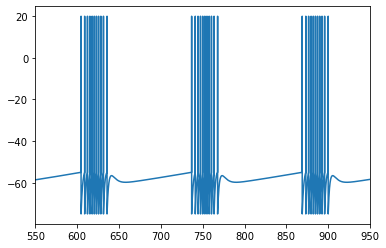

In [6]:
plt.figure()
tvec = np.arange(0, 1000, .01)
plt.plot(tvec, v)
plt.xlim(550, 950)
plt.show()

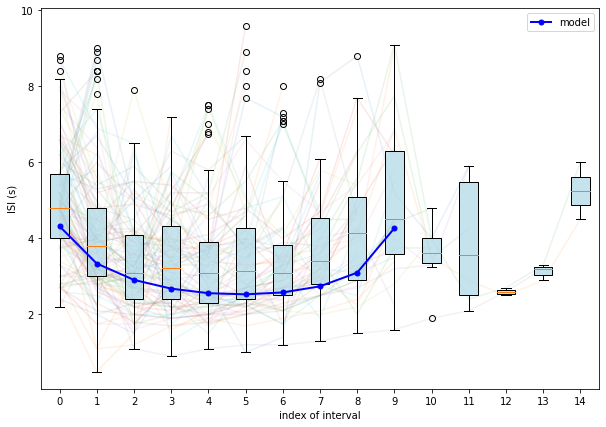

In [7]:
plt.figure(figsize=(10,7))
plt.plot(isi_mat, alpha=.1, zorder=0)
bplot = plt.boxplot(transpose_2d_list(isi_mat.T.tolist()), 
            positions=range(len(isi_mat)), 
            patch_artist=True,
            zorder=1,
            )
# for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
#     plt.setp(bplot[item], color='gray')
# plt.setp(bplot["fliers"], markeredgecolor='gray')
for patch in bplot['boxes']:
    patch.set_facecolor('lightblue')
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))
plt.plot(isi_model, 'b.-', linewidth=2, markersize=10, zorder=2, label='model')
plt.xlabel('index of interval')
plt.ylabel('ISI (s)')
plt.legend()
plt.savefig('./output/isi.pdf', bbox_inches='tight', dpi=300)
plt.show()